In [5]:
import os
import traceback
import requests
from bs4 import BeautifulSoup
from pybliometrics.scopus import ScopusSearch, AbstractRetrieval
import json
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta
import pybliometrics
pybliometrics.scopus.init()
import arxiv
import pandas as pd
from openai import OpenAI
from habanero import Crossref
import warnings
warnings.filterwarnings("ignore")

# Get today's date and the date one month ago
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')


def retrieve_arxiv_data(max_results=400):
    
    # Define the list of keywords to search for
    keywords = ["Africa", "Nigeria", "Kenya", "Ghana", "South Africa", "Liberia", "Egypt", "Lagos", "Abuja", "Morocco", "Rwanda", "Senegal", "Sub-Saharan Africa"]

    # Construct the OR-based search query
    query = " OR ".join(keywords)

    search = arxiv.Search(
        query=query,
        max_results=max_results,
        # sort_by=arxiv.SortCriterion.SubmittedDate
    )

    new_data = []
    for result in search.results():
        new_data.append({
          "Title": result.title,
          "Author": result.authors,
          "Publication_Year": str(result.published.date()),
          "Link": result.pdf_url,
          "Abstract": result.summary
        })

    arxiv_df = pd.DataFrame(new_data)

    # Clean the author column
    def clean_authors(x):
        author_list = []
        for i in x:
            author_list.append(i.name)
        author_string = ", ".join(author_list)
        return author_string
    
    arxiv_df["Author"] = arxiv_df["Author"].map(clean_authors)
    
    # Filter out the Publication Date
    arxiv_df["Publication_Year"].astype(str)
    arxiv_df = arxiv_df[(arxiv_df["Publication_Year"] >= "2015-01-01") & (arxiv_df["Publication_Year"] <= str(end_date))]

    # Reset the index of the Dataframe
    arxiv_df = arxiv_df.reset_index(drop=True)

    # Return the dataframe
    return arxiv_df

def retrieve_scopus_data():
    # Define the query
    query = '''
            (TITLE-ABS-KEY(("knowledge production" OR "research output" OR "academic publishing") AND (Africa OR Nigeria OR Kenya OR Ghana OR South Africa OR Liberia OR Egypt OR Lagos OR Abuja OR Morocco OR Rwanda OR Senegal OR "Sub-Saharan Africa"))) 
            AND DOCTYPE(ar) 
            AND SRCTYPE(j) 
            AND PUBYEAR > 2014 AND PUBYEAR < 2026
            '''

    # Perform Scopus search
    x = ScopusSearch(query=query, view="STANDARD", cursor=None, verbose=True)
    
    # Extract results
    scopus_data = []
    for result in x.results:
        scopus_data.append({
            "Title": result.title,
            "Author": result.creator,
            "Publication_Year": result.coverDate,
            "Link": f"http://dx.doi.org/{result.doi}" if result.doi else "No DOI available"
        })
    
    scopus_df = pd.DataFrame(scopus_data)

    # Ensure only results within the date range
    scopus_df = scopus_df[
        (scopus_df["Publication_Year"] >= "2015-01-01") & 
        (scopus_df["Publication_Year"] <= end_date)
    ].reset_index(drop=True)

    # Fetch abstracts using Crossref from Habanero
    cr = Crossref()
    abstracts = []
    
    for link in scopus_df["Link"]:
        if "No DOI available" in link:
            abstracts.append("No abstract available")
            continue
        
        doi = link.split("doi.org/")[-1]
        try:
            paper = cr.works(ids=doi)
            abstract_raw = paper["message"].get("abstract", "No abstract available")
            soup = BeautifulSoup(abstract_raw, "html.parser")
            abstracts.append(soup.get_text())
        except Exception as e:
            abstracts.append("No abstract available")  # Handle errors gracefully

    scopus_df["Abstract"] = abstracts

    # Remove rows with no abstracts
    scopus_df = scopus_df[scopus_df["Abstract"] != "No abstract available"]

    # return the dataframe
    return scopus_df

# Merge both dataframes together
def merge_dataframes():
    df_1 = retrieve_arxiv_data()
    df_2 = retrieve_scopus_data()
    df = pd.concat([df_1, df_2], axis = 0)

    # Reset the index
    df = df.reset_index(drop=True)
    return df

df = merge_dataframes()

In [6]:
df.head()

,Title,Author,Publication_Year,Link,Abstract
0,A Continent-Wide Assessment of Cyber Vulnerabi...,"Abdijabar Yussuf Mohamed, Samuel Kang'ara Kamau",2023-01-08,http://arxiv.org/pdf/2301.03008v1,As the internet penetration rate in Africa inc...
1,Physics Masterclasses in Africa and the World,"Uta Bilow, Kenneth Cecire",2022-05-24,http://arxiv.org/pdf/2206.07004v1,International Masterclasses (IMC) enable high ...
2,Modelling spatio-temporal trends of air pollut...,"Paterne Gahungu, Jean Remy Kubwimana, Lionel J...",2022-08-21,http://arxiv.org/pdf/2208.12719v1,Atmospheric pollution remains one of the major...
3,Radio astronomy in Africa: the case of Ghana,"Bernard Duah Asabere, Michael Gaylard, Cathy H...",2015-03-30,http://arxiv.org/pdf/1503.08850v2,South Africa has played a leading role in radi...
4,Modelling the impact of vaccination on the COV...,"Dephney Mathebula, Abigail Amankwah, Kossi Amo...",2022-09-19,http://arxiv.org/pdf/2209.08694v4,The rapid development of vaccines to combat th...


Checking the shape of the dataset

In [7]:
df.shape

(257, 5)

Checking for duplicate rows

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
from dotenv import load_dotenv
import os

load_dotenv()

def categorize_topics():
    # Set up OpenAI API client
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    topic_category = []
    for title in df["Title"]:
        # Query OpenAI API for topic categorization
        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an academic assistant. Given a research paper title, classify it into a relevant academic category. Your response should only contain the category name."
                },
                {
                    "role": "user",
                    "content": f"Categorize the research paper titled: '{title}'. Only return the topic category."
                }
            ],
            temperature=0  # Ensures consistency in responses
        )

        # Extract and print topic categorization
        topic_categorization = completion.choices[0].message.content.strip()
        topic_category.append(topic_categorization)

    # Merge topic categories to the dataframe
    df["Topic_Category"] = topic_category

    # Reset the index of the dataframe
    df.reset_index(drop=True, inplace=True)

    # Return the dataframe with topic categories
    return df

In [10]:
df = categorize_topics()

In [11]:
# !pipx install --force poetry

In [12]:
df.head()

,Title,Author,Publication_Year,Link,Abstract,Topic_Category
0,A Continent-Wide Assessment of Cyber Vulnerabi...,"Abdijabar Yussuf Mohamed, Samuel Kang'ara Kamau",2023-01-08,http://arxiv.org/pdf/2301.03008v1,As the internet penetration rate in Africa inc...,Cybersecurity
1,Physics Masterclasses in Africa and the World,"Uta Bilow, Kenneth Cecire",2022-05-24,http://arxiv.org/pdf/2206.07004v1,International Masterclasses (IMC) enable high ...,Physics
2,Modelling spatio-temporal trends of air pollut...,"Paterne Gahungu, Jean Remy Kubwimana, Lionel J...",2022-08-21,http://arxiv.org/pdf/2208.12719v1,Atmospheric pollution remains one of the major...,Environmental Science
3,Radio astronomy in Africa: the case of Ghana,"Bernard Duah Asabere, Michael Gaylard, Cathy H...",2015-03-30,http://arxiv.org/pdf/1503.08850v2,South Africa has played a leading role in radi...,Astronomy
4,Modelling the impact of vaccination on the COV...,"Dephney Mathebula, Abigail Amankwah, Kossi Amo...",2022-09-19,http://arxiv.org/pdf/2209.08694v4,The rapid development of vaccines to combat th...,Epidemiology


THEMATIC MAPPING

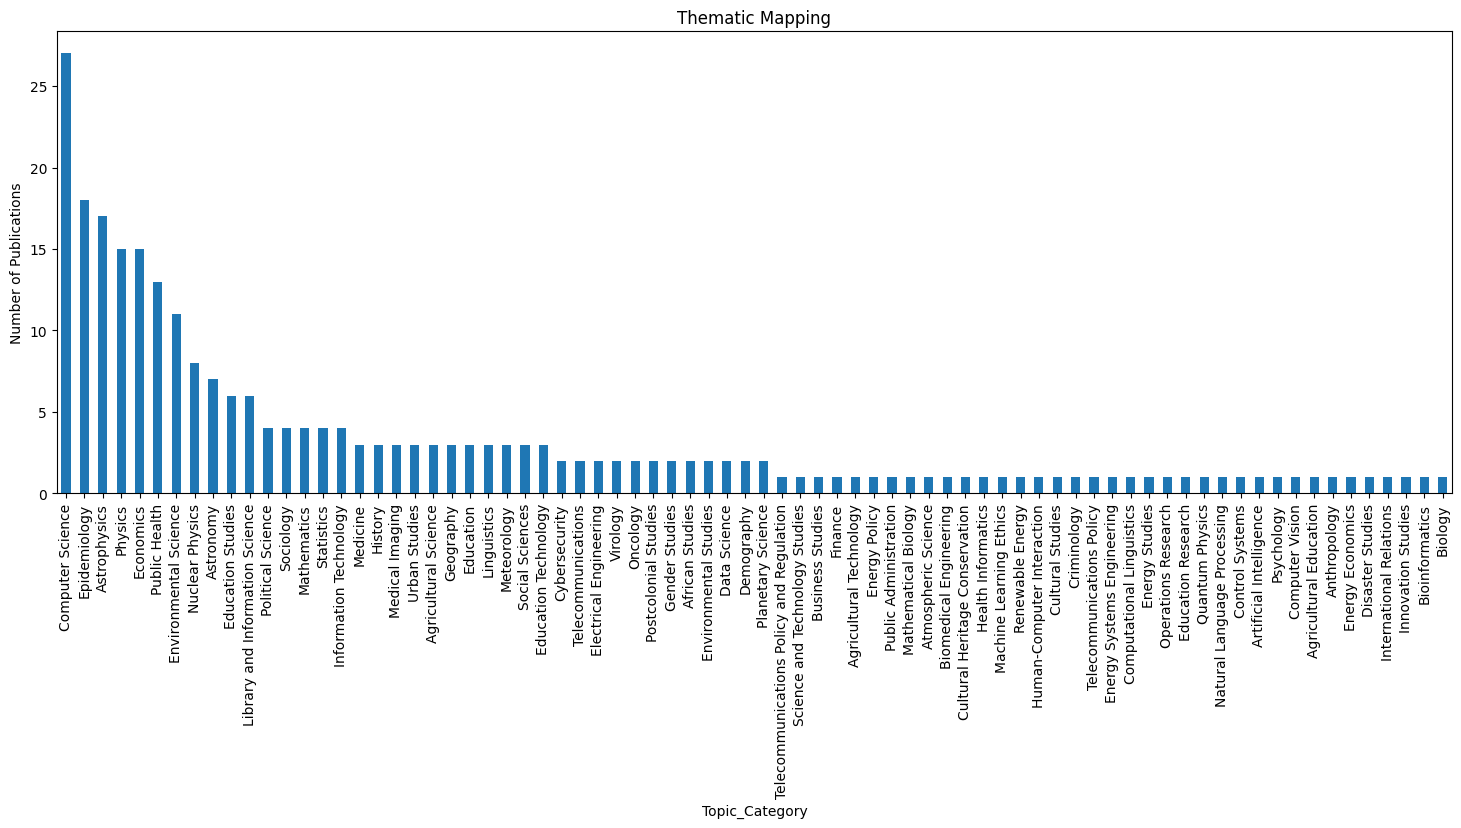

In [13]:
import matplotlib.pyplot as plt

df["Topic_Category"].value_counts().plot(
    kind="bar",
    title="Thematic Mapping",
    ylabel= "Number of Publications",
    figsize = (18, 6)
    )
plt.show()

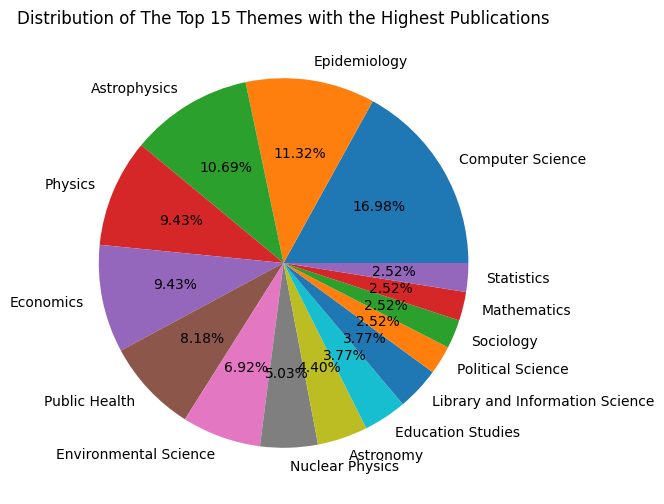

In [14]:
df["Topic_Category"].value_counts()[:15].plot(
    kind="pie",
    title="Distribution of The Top 15 Themes with the Highest Publications",
    autopct = "%.2f%%",
    figsize = (18,6),
    ylabel = ""
)
plt.show()

In [15]:
df["Link"][1]

'http://arxiv.org/pdf/2206.07004v1'

In [16]:
df['Year'] = pd.to_datetime(df['Publication_Year']).dt.year

In [17]:
theme_trends = df.groupby(['Year', 'Topic_Category']).size().reset_index(name='Count')

In [18]:

# Step 1: Count the top 20 most frequent themes
top_20_themes = df['Topic_Category'].value_counts().nlargest(20).index

# Step 2: Filter the dataframe to only include those top 20 themes
df_top_20 = df[df['Topic_Category'].isin(top_20_themes)]

# Optional: Check the result
# print(df_top_20['Topic_Category'].value_counts())
df_top_20 = df_top_20.groupby(["Year", "Topic_Category"]).size().reset_index(name="Count")

In [19]:
# theme_trends = theme_trends.sort_values(by="Count", ascending=False)
# theme_trends = df_top_20.sort_values(by="Count", ascending=False)
df_top_20.head()

,Year,Topic_Category,Count
0,2015,Astronomy,1
1,2015,Economics,1
2,2015,Epidemiology,4
3,2015,Information Technology,1
4,2015,Library and Information Science,1


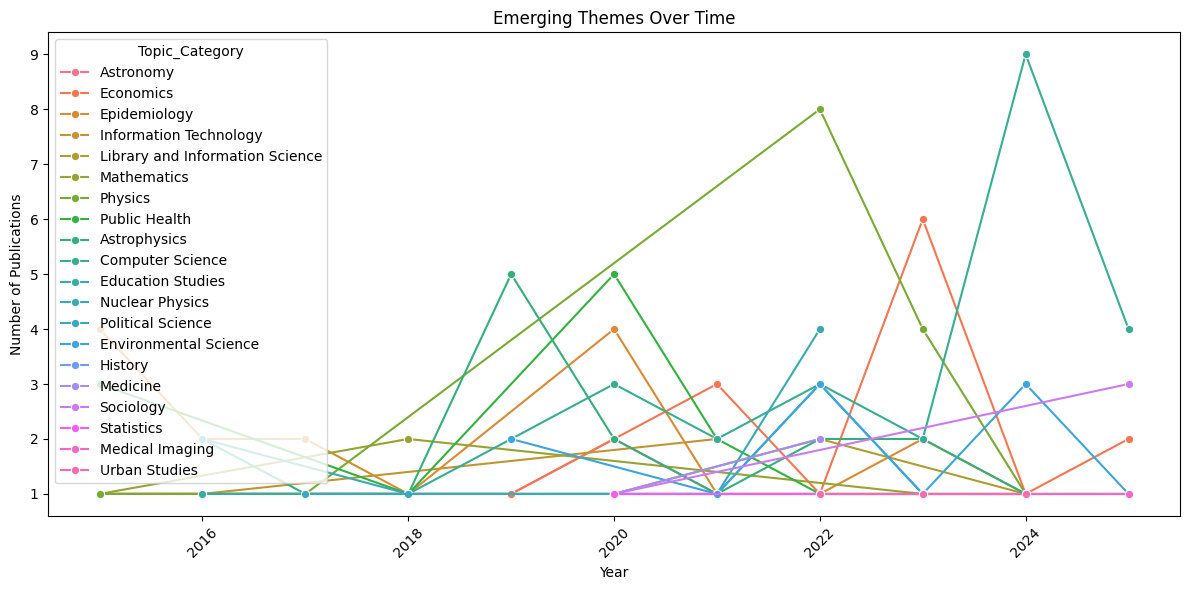

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top_20, x='Year', y='Count', hue='Topic_Category', marker='o')
plt.title('Emerging Themes Over Time')
plt.ylabel('Number of Publications')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

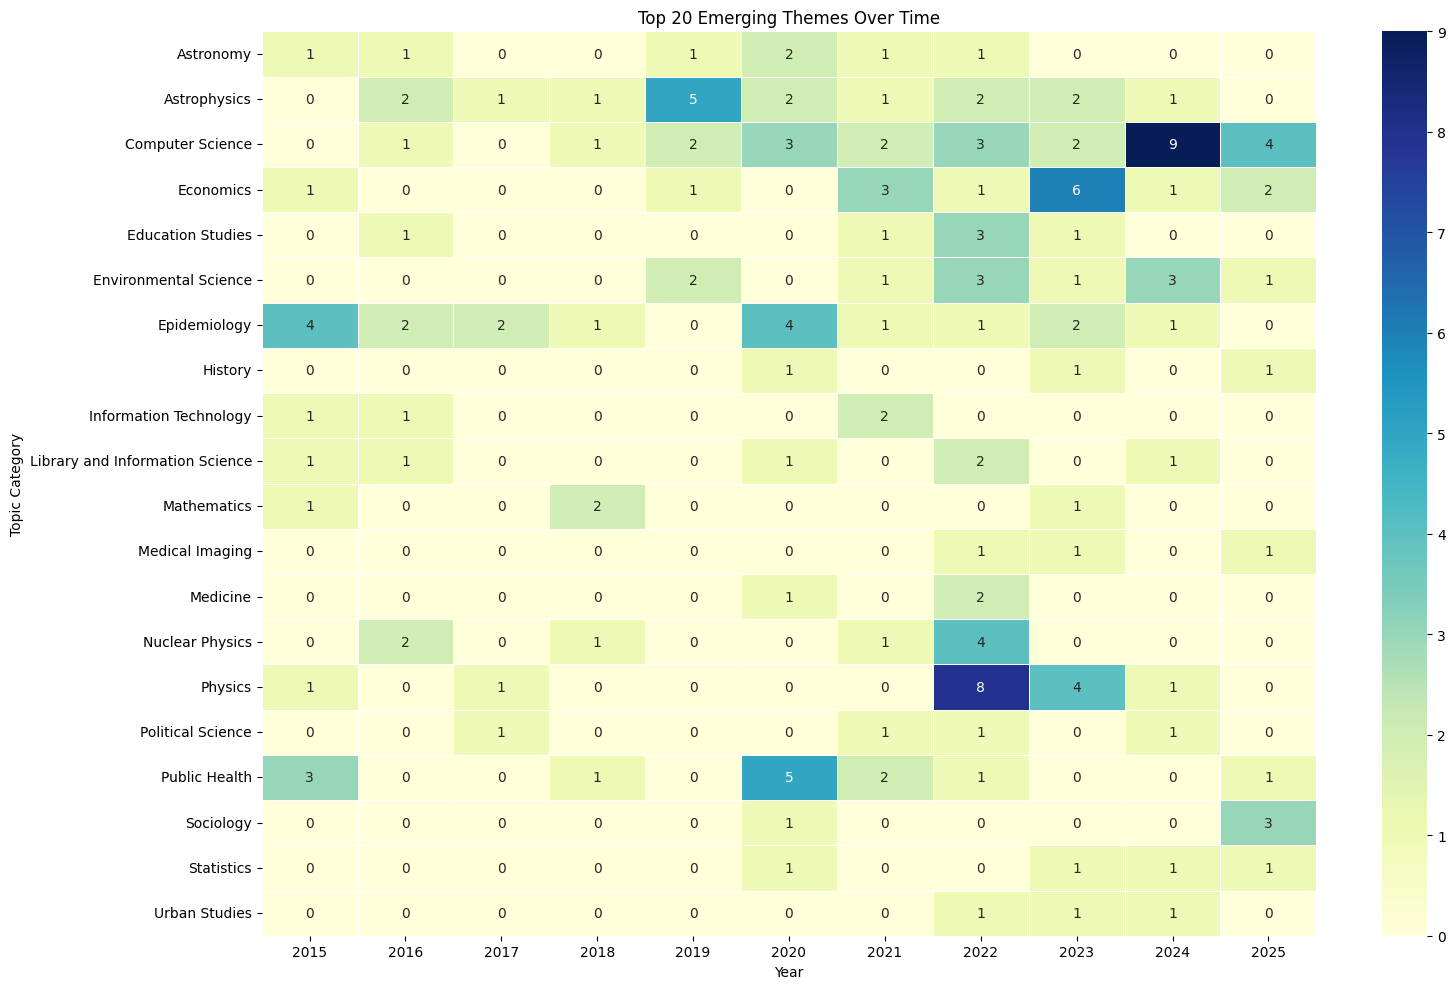

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert publication date to year (if needed)
df['Publication_Year'] = pd.to_datetime(df['Publication_Year'], errors='coerce').dt.year

# Step 2: Get top 20 themes
top_20_themes = df['Topic_Category'].value_counts().nlargest(20).index
df_top_20 = df[df['Topic_Category'].isin(top_20_themes)]

# Step 3: Create pivot table (rows=Theme, cols=Year, values=Counts)
heatmap_data = df_top_20.pivot_table(index='Topic_Category',
                                      columns='Publication_Year',
                                      values='Title',  # or any column
                                      aggfunc='count',
                                      fill_value=0)

# Step 4: Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, annot=True, fmt="d")
plt.title('Top 20 Emerging Themes Over Time')
plt.xlabel('Year')
plt.ylabel('Topic Category')
plt.tight_layout()
plt.show()


TOPIC MODELING USING BERTOPIC

In [23]:
# Clean the titles column
titles = df["Title"].dropna().to_list()

In [25]:
len(titles)

257

In [26]:
from bertopic import BERTopic

In [ ]:
model =BERTopic(verbose=True, embedding_model="paraphrase-MiniLLM-")